# Attributions

**Emily:** Image processing, thresholding, interpulse times

**Naveen:** Frequentist stats

**Chris:** Looked over final work


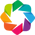

Loading BokehJS ...

In [1]:
import glob
import os

import numpy as np
import pandas as pd
import scipy.signal 
from scipy.signal import argrelmax

# Image processing tools
import skimage
import skimage.io

import bebi103

import bokeh
import holoviews as hv
hv.extension('bokeh')
from bokeh.layouts import column
bokeh.io.output_notebook()

We start by reading in the images, loading and displaying them. We'll do the daytime first.

In [2]:
# The directory containing daytime data
data_dir_day = '../data/cassiopea_pulsation/day'

# Glob string for images
im_glob_day = os.path.join(data_dir_day, '*.TIF')

# Get list of files in directory
im_list_day = glob.glob(im_glob_day)

# Read in the image using skimage
im_day = skimage.io.imread(im_list_day[0])

# Since we know it's an RBG image, from the tutorial
# test to see if each R, G, and B value is the same
((im_day[:,:,0] == im_day[:,:,1]) &  (im_day[:,:,1] == im_day[:,:,2])).all()

# Just slice the red channel
im_day = im_day[:,:,0]

# From the tutorial, we had gotten the appropriate scaling
xy = np.array([[348.2218, 243.6252],[500.1257, 239.2508],])
box_length = np.sqrt((xy[1][1] - xy[0][1])**2 + (xy[1][0] - xy[0][0])**2)
interpixel_distance = 4/box_length*2.54

p = bebi103.viz.imshow(im_day, interpixel_distance = interpixel_distance, length_units='cm')
bokeh.io.show(p)

Now, we will be loading the stack of images and only selecting for one channel. Additionally, we will define the frames per second and make sure we're looking at the appropriate time range.

In [3]:
def squish_rgb(fname, **kwargs):
    """
    Only take one channel. (Need to explicitly have the **kwargs to play
    nicely with skimage.io.ImageCollection.)
    """
    im = skimage.io.imread(fname)
    return im[:,:,0]

ic_day = skimage.io.ImageCollection(im_glob_day,
                                conserve_memory=True, 
                                load_func=squish_rgb)

# Generate time points in units of seconds
fps = 15
t = np.arange(0, len(ic_day)) / fps

Setting the region of interest. We will click on the points for the corners we want and store them in a CSV file to read in later on.

**Please note that in our submission we have also added to our homework box a .csv file for this purpose**

In [4]:
bokeh.io.show(bebi103.viz.imshow(im_day, flip=False, record_clicks=True))

**Here we are reading in the CSV file included in our homework submission.**

Then, we create an array of ROIs to use.

In [5]:
corners = pd.read_csv('box_coordinates.csv', header=1, 
                          names=["box_num","corner_num","x","y"])

numframes = len(ic_day)
total_int_day = np.zeros((8,numframes))

corners_list = [corners.loc[corners.box_num == i] for i in range(1,9)]
verts_list = [np.vstack((vertices.x.values, vertices.y.values)).T for vertices in corners_list]
roi_params_list = [bebi103.image.verts_to_roi(box, *ic_day[0].shape) for box in verts_list]

Note that the order of the roi_params_list indices are:
- 0 = roi
- 1 = roi_bbox
- 2 = roi_box

For our convenience, we'll define a load function that only gives the region bounded by the ROI

In [6]:
# Define load_func that only gives region bounding ROI
def load_roi(fname, roi_bbox=None, **kwargs):
    """
    Image loading function to only load ROI.
    """
    if roi_bbox is None:
        return skimage.io.imread(fname)[:,:,0]
    else:
        return skimage.io.imread(fname)[:,:,0][roi_bbox] 

Now, we'll calculate the total intensity for each frame, per box.

In [7]:
for i in range(numframes):
    im_day = ic_day[i]

    for boxnum in range(1,9):
        # Make ROI
        roi, roi_bbox, roi_box = roi_params_list[boxnum - 1]
        total_int_day[boxnum-1, i] = ((im_day*roi).sum())
        

/Users/narunach/anaconda/lib/python3.6/site-packages/skimage/external/tifffile/tifffile.py:2611: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)


Now, we can normalize the intensities to be between -1 and 1 for easier comparison, and plot them.

In [8]:
for boxnum in range (1,9):
    total_int_day[boxnum-1] -= total_int_day[boxnum-1].mean()
    total_int_day[boxnum-1] = 1 + 2 * ((total_int_day[boxnum-1] - total_int_day[boxnum-1].max()) 
                        / (total_int_day[boxnum-1].max() - total_int_day[boxnum-1].min()))

bokeh_titles = ["Box 1 Day", "Box 2 Day", "Box 3 Day", "Box 4 Day", "Box 5 Day", "Box 6 Day", "Box 7 Day", "Box 8 Day"]    
    
# Look at images
for i in range(0, 8):
    p = bokeh.plotting.figure(plot_width=650,
                              plot_height=300,
                              x_axis_label='time (s)', 
                              y_axis_label='total intensity',
                              title = bokeh_titles[i])
    p.line(t, total_int_day[i], line_width=2, line_join='bevel')
    bokeh.io.show(p)

Now, we need to do the same process for the night. Let's just check that the night images have the same position by displaying the image and again only taking one channel.

In [9]:
# The directory containing daytime data
data_dir_night = '../data/cassiopea_pulsation/night'

# Glob string for images
im_glob_night = os.path.join(data_dir_night, '*.TIF')

# Get list of files in directory
im_list_night = glob.glob(im_glob_night)

# Read in the image using skimage
im_night = skimage.io.imread(im_list_night[0])

# Since we know it's an RBG image, from the tutorial
# test to see if each R, G, and B value is the same
((im_night[:,:,0] == im_night[:,:,1]) &  (im_night[:,:,1] == im_night[:,:,2])).all()

# Just slice the red channel
im_night = im_night[:,:,0]

# From the tutorial, we had gotten the appropriate scaling
xy = np.array([[348.2218, 243.6252],[500.1257, 239.2508],])
box_length = np.sqrt((xy[1][1] - xy[0][1])**2 + (xy[1][0] - xy[0][0])**2)
interpixel_distance = 4/box_length*2.54

p = bebi103.viz.imshow(im_night, interpixel_distance = interpixel_distance, length_units='cm')
bokeh.io.show(p)

Looks okay, frame not shifted drastically. Now we'll define the same ROIs and calculate the total intensity per frame per box at night.

In [10]:
ic_night = skimage.io.ImageCollection(im_glob_night,
                                conserve_memory=True, 
                                load_func=squish_rgb)

total_int_night = np.zeros((8,numframes))
for i in range(numframes):
    im_night = ic_night[i]

    for boxnum in range(1,9):
        # Make ROI
        roi, roi_bbox, roi_box = roi_params_list[boxnum - 1]
        total_int_night[boxnum-1, i] = ((im_night*roi).sum())

Again, we'll need to normalize it before plotting.

In [11]:
for boxnum in range (1,9):
    total_int_night[boxnum-1] -= total_int_night[boxnum-1].mean()
    total_int_night[boxnum-1] = 1 + 2 * ((total_int_night[boxnum-1] - total_int_night[boxnum-1].max()) 
                        / (total_int_night[boxnum-1].max() - total_int_night[boxnum-1].min()))

bokeh_titles = ["Box 1 Night", "Box 2 Night", "Box 3 Night", "Box 4 Night", "Box 5 Night", "Box 6 Night", "Box 7 Night",
                "Box 8 Night"]    
    
# Look at images
for i in range(0, 8):
    p = bokeh.plotting.figure(plot_width=650,
                              plot_height=300,
                              x_axis_label='time (s)', 
                              y_axis_label='total intensity',
                              title = bokeh_titles[i])
    p.line(t, total_int_night[i], line_width=2, line_join='bevel')
    bokeh.io.show(p)

Just by comparing the night and day for each box, we can tell that there is a distinct difference. The daytime intensities actively fluctuate up and down (pulsing), while the nighttime intensities have pauses in the fluctations where they reside at lower intensities (some amount of noise), indicating "rest" time.

Notably, Box 2 seems to contain a jellyfish that is unusual in that its day and night activity seem more similar to each other: during the day, it exhibits periods of rest/lower intensity, and during the night it exhibits higher activity than the rest of the jellyfish.

In order to determine if there truly is a difference between the two, we must set a threshold for what we are defining as "rest" for each jellyfish. In this case, we will define an intensity max. for which we decide that anything below it is noise/jellyfish is resting, and anything above it is activity/pulsing by the jellyfish. Because we have plotted the intensities per frame, we can give an estimate for the noise threshold just by looking at the plots. We want to ignore all the values we perceive as noise, which are those regions in the intensity plot where the local mean is lower than the rest of the graph. We will define them here:
- Box 1: 0: 
- Box 2: -0.1
- Box 3: 0
- Box 4: 0.3
- Box 5: 0.2
- Box 6: 0.1
- Box 7: 0.15
- Box 8: 0.1

Unfortunately, this means we need to manually set the threshold for each jellyfish. Let's do that now.

In [12]:
# Masking out the part that does not exceed threshold
thres = [0, -0.1, 0, 0.3, 0.2, 0.1, 0.15, 0.1]
thres_day = []
thres_night = []

for i in range(0,8):
    thres_day.append(total_int_day[i])
    thres_night.append(total_int_night[i])

for i in range(0,8):
    thres_day[i][total_int_day[i]<=thres[i]] = 0
    thres_night[i][total_int_night[i]<=thres[i]]=0


We want to calculate the interpulse time for each jellyfish from the thresholded data. We can do this by finding the times between the local maxima. Because we want to draw a conclusion about this species of jellyfish in general during the day vs. night, we can now collapse all our data from the day together, and all our data from the night together (we don't need to differentiate between jellyfish anymore) and do EDA in this way. Let's make the the dataframe.

In [13]:
maxima_day = []
maxima_night = []
interpulse_day = []
interpulse_night =[]

for i in range(0, 8):
    maxima_day.append(argrelmax(thres_day[i])[0])
    maxima_night.append(argrelmax(thres_night[i])[0])
    for j in range(0, len(maxima_day[i])-1):
        interpulse_day.append((maxima_day[i][j+1]-maxima_day[i][j]))
    for k in range(0, len(maxima_night[i])-1):
        interpulse_night.append((maxima_night[i][k+1]-maxima_night[i][k]))

df=pd.DataFrame({'Day Interpulse Times (s)':np.transpose(interpulse_day) / fps})
df['Night Interpulse Times (s)'] = pd.DataFrame(np.transpose(interpulse_night) / fps)

df.head()

Day Interpulse Times (s)  Night Interpulse Times (s)
0                  1.600000                    0.800000
1                  1.466667                    0.133333
2                  1.533333                    1.200000
3                  1.666667                    1.133333
4                  1.666667                    0.266667

I created a somewhat unruly/untidy data frame for my own convenience, so let me clean it up now.

In [14]:
# Making a tidy data frame
df_tidy = pd.DataFrame(columns=['Timeframe', 'Interpulse Time (s)'])

# specifying variables from original
orig = ['Day', 'Night']

for i in orig:
    d = {'Timeframe': i, 'Interpulse Time (s)':df[i + ' Interpulse Times (s)']}
    df_temp = pd.DataFrame(data = d, columns=['Timeframe', 'Interpulse Time (s)'])
    df_tidy = pd.concat([df_tidy, df_temp])

df_tidy = df_tidy.dropna().reset_index().drop('index', 1)

df_tidy.head()

Timeframe  Interpulse Time (s)
0       Day             1.600000
1       Day             1.466667
2       Day             1.533333
3       Day             1.666667
4       Day             1.666667

There are a TON of data points, so let's summarize it using a box-and-whisker plot and an ECDF:

In [15]:
p = bebi103.viz.boxwhisker(df_tidy, 'Timeframe', 'Interpulse Time (s)',plot_width=500, plot_height=600)
bokeh.io.show(p)

daytime = df_tidy['Timeframe']=='Day'
nighttime = df_tidy['Timeframe']=='Night'

df_daytime = df_tidy.loc[daytime]
df_nighttime = df_tidy.loc[nighttime]

print('Daytime (Median, Mean) Interpulse Value:', (np.percentile(df_daytime['Interpulse Time (s)'], 50), np.mean(df_daytime['Interpulse Time (s)'])))
print('Nighttime (Median, Mean) Interpulse Value:', (np.percentile(df_nighttime['Interpulse Time (s)'], 50), np.mean(df_nighttime['Interpulse Time (s)']) ))

Daytime (Median, Mean) Interpulse Value: (0.93333333333333335, 1.0980006894174257)
Nighttime (Median, Mean) Interpulse Value: (0.46666666666666667, 0.8369183040331079)


We can see from the box-and-whisker plot if we zoom in that the daytime median and mean interpulse times are actually longer than the median and mean nighttime interpulse times. This indicates that even though we can see the rest times (periods where the regional mean is low intensity, mostly noise) when the activity intensity is plotted, they rest infrequently. As a result, the large interpulse times that result from resting are not enough to skew the mean of the nighttime interpulse times to be larger than the daytime.

In [16]:
# Make collection of staircase ECDFs
p = bebi103.viz.ecdf_collection(df_tidy, 'Timeframe', 'Interpulse Time (s)', formal=True, line_width=2)


bokeh.io.show(p)

We can kind of see the presence of the nighttime rest bouts more in the ECDF. The night and day interpulse times are about the same when rising, but at the end when it's close to 1, the night ECDF takes a bit longer to reach 1, due to those longer rest bouts that are viewed as "outliers" on the box-and-whisker plots.

One question we might be curious to answer is, if the day and night distributions were identical, how often would we observe a difference in means as large as the observed difference? We are curious about this because the ECDFs for both look similar, yet the box-and-whisker plots look very different. Which do we believe? To test this, we use a NHST.

Let's make our null hypothesis be: **the day and night distributions are identical**.

Our test statistic will be: **the difference in means between the day and night distributions**.

Our simulation will be: **combine the day (size m) and night (size n) data sets, permute the result, call the first m values the day set and the next n values the night set, and compute the difference in means**.

The definition of extreme will be: **the difference of means from the simulation is greater than or equal to the difference of means between the original distributions**.

First, let's create some helper functions to concatenate two datasets and shuffle them:

In [17]:
import numba

@numba.jit(nopython=True)
def draw_perm_sample(x, y):
    """Generate a permutation sample."""
    concat_data = np.concatenate((x, y))
    np.random.shuffle(concat_data)
    return concat_data[:len(x)], concat_data[len(x):]

Next, let's create a helper function to draw values of the test statistic:

In [18]:
@numba.jit(nopython=True)
def draw_perm_reps_diff_mean(x, y, size=10000):
    """
    Generate array of permuation replicates.
    """
    out = np.empty(size)
    for i in range(size):
        x_perm, y_perm = draw_perm_sample(x, y)
        out[i] = np.mean(x_perm) - np.mean(y_perm)
    return out

Now, let's compare the test statistic for simulations to the value of the test statistic for the original data:

In [19]:
day_vals = df_tidy.loc[df_tidy["Timeframe"]=='Day']["Interpulse Time (s)"].as_matrix()
night_vals = df_tidy.loc[df_tidy["Timeframe"]=='Night']["Interpulse Time (s)"].as_matrix()

perm_reps = draw_perm_reps_diff_mean(day_vals, night_vals, size=100000)

diff_mean = np.mean(day_vals) - np.mean(night_vals)

p_val = np.sum(perm_reps >= diff_mean) / len(perm_reps)

print('p-value =', p_val)

p-value = 0.0


The low p-value suggests that it is probably okay to assume that the day and night distributions are different based on their means.

What if we did the same test with standard deviations, changing the test statistic to the difference of standard deviations between the day and night distributions?

In [20]:
@numba.jit(nopython=True)
def draw_perm_reps_diff_std(x, y, size=10000):
    """
    Generate array of permuation replicates.
    """
    out = np.empty(size)
    for i in range(size):
        x_perm, y_perm = draw_perm_sample(x, y)
        out[i] = np.std(x_perm) - np.std(y_perm)
    return out

In [21]:
perm_reps = draw_perm_reps_diff_std(night_vals, day_vals, size=100000)

diff_std = np.std(night_vals) - np.std(day_vals)

p_val = np.sum(perm_reps >= diff_std) / len(perm_reps)

print('p-value =', p_val)

p-value = 0.0


This gives further support that the distributions are different. The reason for such a low p value is likely the long tail of the night distribution. With this in mind, we can now report a mean and standard deviation for both distributions without proposing any particular model for either:

In [22]:
print('Daytime (Mean, Std) Interpulse Value: (%.2f, %.2f)' % (np.mean(df_daytime['Interpulse Time (s)']), np.std(df_daytime['Interpulse Time (s)'])))
print('Nighttime (Mean, Std) Interpulse Value: (%.2f, %.2f)' % (np.mean(df_nighttime['Interpulse Time (s)']), np.std(df_nighttime['Interpulse Time (s)'])))

Daytime (Mean, Std) Interpulse Value: (1.10, 0.67)
Nighttime (Mean, Std) Interpulse Value: (0.84, 1.95)


What have we learned from this analysis? Well, first, we learn that jellyfish tend to take longer time between pulses during the day with low spread, while at night they tend to take shorter times between pulses with large spread. The second thing we learned is that the jellyfish experience very different interpulse time models during the day and during night.

One possible explanation for these differences is that during the day, the jellyfish experience a near-uniform pulsing history, whereas at night they tend to pulse faster but tend to take much longer, infrequent breaks between pulses. The infrequent, long breaks, if supported by additional testing, could potentially be characterized as sleeping behavior. Alternatively, the different models themselves could be taken as a whole and characterized as "non-sleeping" and "sleeping" behavior. In any case, the difference in behavior is significant, and the hypothesis testing and the methods used above help illustrate the nature of this difference.